# Importing Libraries

* System Append to set proper path


In [1]:
sys.path.append('../')

* Default

In [2]:
import lasio
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
import os
import time

* Pandas Options

In [3]:
pd.set_option('max_columns', None)


* Tqdm Progress Bar

In [4]:
%%capture
from tqdm import tqdm_notebook

# Checkpoint Import

In [5]:
df = pd.read_csv('../checkpoints/litho_data_3.csv.gz', compression='gzip') # already non-null litho classes

In [6]:
df.head()

,CALI,NPHI,RHOB,GR,DTC,RDEP,LITHOLOGY_GEOLINK,DEPTH,WELL_NAME,DRDN,AI,LITHOLOGY_GEOLINK_2,LITHOLOGY_GEOLINK_3
0,14.438001,0.447725,2.363,60.285748,134.253601,0.737006,6,2215.917725,15_9-12,7.184164,317.241248,5,5
1,14.633000,0.432095,2.340,63.250000,129.101868,0.741000,6,2216.070068,15_9-12,6.203159,302.098359,5,5
2,14.813001,0.410166,2.314,61.405998,122.476944,0.752000,6,2216.222412,15_9-12,4.952206,283.411635,5,5
3,14.383001,0.414143,2.293,62.561596,116.908607,0.739962,6,2216.375000,15_9-12,4.664760,268.071435,5,5
4,14.202999,0.439923,2.275,61.691055,115.390953,0.715966,6,2216.527344,15_9-12,5.164095,262.514429,5,5


* Classes Balance

Text(0.5, 1.0, 'Lithology Classes - Target Variable Balance')

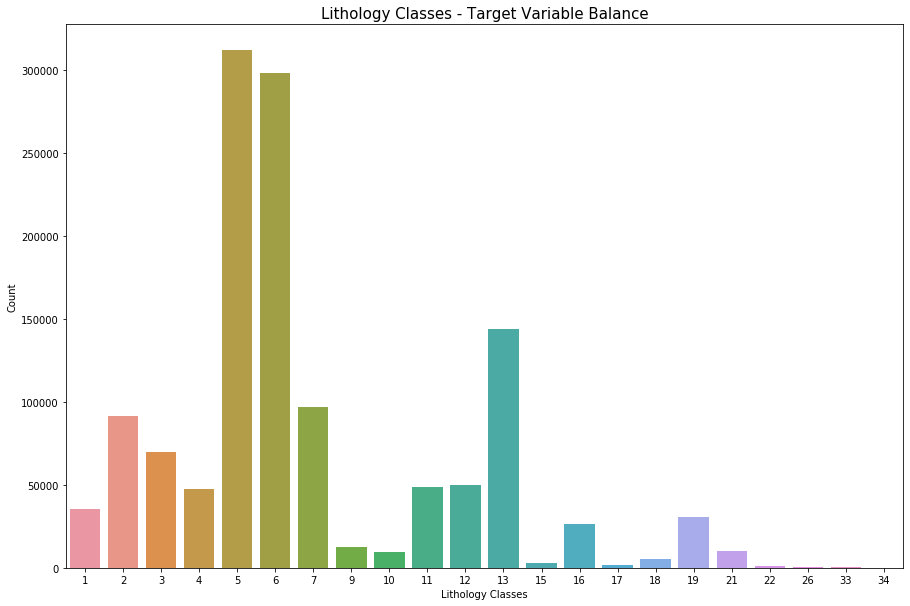

In [7]:
plt.figure(figsize=(15,10))

sns.barplot(x=df['LITHOLOGY_GEOLINK'].value_counts().index, y=df['LITHOLOGY_GEOLINK'].value_counts())
plt.xlabel('Lithology Classes', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Lithology Classes - Target Variable Balance', fontsize=15)

* Merging Some Classes for better geological behavior

In [8]:
df['LITHOLOGY_GEOLINK_2'] = df['LITHOLOGY_GEOLINK']

for code in tqdm_notebook(df.index, desc='Regrouping lithologies'):

    if (df['LITHOLOGY_GEOLINK_2'][code] == 2 or df['LITHOLOGY_GEOLINK_2'][code] == 3):

        df['LITHOLOGY_GEOLINK_2'][code] = 1

    elif df['LITHOLOGY_GEOLINK_2'][code] == 6:

        df['LITHOLOGY_GEOLINK_2'][code] = 5


    elif df['LITHOLOGY_GEOLINK_2'][code] == 34:

        df['LITHOLOGY_GEOLINK_2'][code] = 33


    elif df['LITHOLOGY_GEOLINK_2'][code] == 13:

        df['LITHOLOGY_GEOLINK_2'][code] = 12

    else:
        
        pass

Text(0.5, 1.0, 'Condensed Lithology Classes - Target Variable Balance')

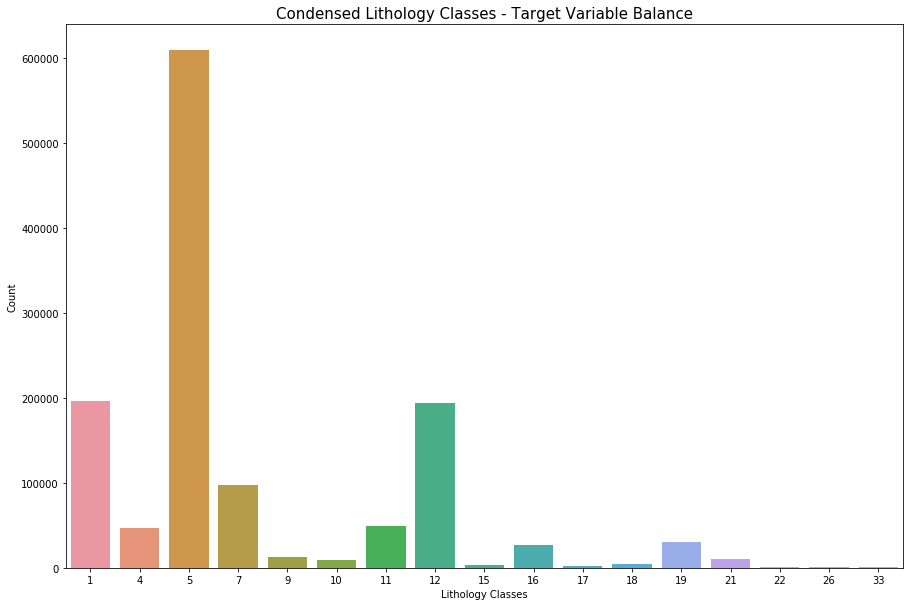

In [9]:
plt.figure(figsize=(15,10))

sns.barplot(x=df['LITHOLOGY_GEOLINK_2'].value_counts().index, y=df['LITHOLOGY_GEOLINK_2'].value_counts())
plt.xlabel('Lithology Classes', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Condensed Lithology Classes - Target Variable Balance', fontsize=15)

# Lithology Code Prediction

* LITHOLOGY_GEOLINK non NULL data

In [10]:
litho_data = df.drop(columns=['WELL_NAME', 'LITHOLOGY_GEOLINK', 'LITHOLOGY_GEOLINK_3']) 


In [11]:
len(litho_data) # samples to build the DL model

1294715

    * Converting LITHOLOGY_GEOLINK to int type

In [12]:
litho_data['LITHOLOGY_GEOLINK_2'] = litho_data['LITHOLOGY_GEOLINK_2'].astype(int)

* Reduciong Dataset Size for training

In [13]:
litho_data["Set"] = np.random.choice(["train_red", "rest"], p =[.8, .2], size=(litho_data.shape[0],))

train = litho_data[litho_data.Set == 'train_red']

In [14]:
print(train.shape, litho_data.shape)

(1036383, 11) (1294715, 11)


* Dataset Creation

In [15]:
from sklearn.model_selection import train_test_split

X = train.drop(columns=['LITHOLOGY_GEOLINK_2', 'Set'])

Y = train['LITHOLOGY_GEOLINK_2']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=42)

In [16]:
print('### Training Dataset: ### ', x_train.shape, y_train.shape)
print('### Validation Dataset: ### ', x_val.shape, y_val.shape)
print('### Test Dataset: ### ', x_test.shape, y_test.shape)

### Training Dataset: ###  (663284, 9) (663284,)
### Validation Dataset: ###  (165822, 9) (165822,)
### Test Dataset: ###  (207277, 9) (207277,)


* Building Model

In [17]:
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = str(1)

torch.cuda.set_device(1)

In [18]:
clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-3),
                       scheduler_params={"gamma":0.9, "step_size":50},
                       gamma=1.2,
                       lambda_sparse=0, 
                       n_independent=10,
                       n_shared=5,	
                       n_steps=5,
                       n_a=64,
                       n_d=64,
                       momentum=0.6, 
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax') 

Device used : cuda


    * Normalizing Data

In [19]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

x_train = std_scaler.fit_transform(x_train)
x_val = std_scaler.fit_transform(x_val)

    * Training

In [20]:
max_epochs = 200

clf.fit(
    X_train=x_train, y_train=y_train,
    eval_set=[(x_train, y_train), (x_val, y_val)],
    eval_name=['train', 'valid'],
    eval_metric=['balanced_accuracy'],
    max_epochs=max_epochs,
    patience=30,
    num_workers=30,
    drop_last=False,
    batch_size=8192,
    virtual_batch_size=8192,
    weights=1
)

epoch 0  | loss: 3.05996 | train_balanced_accuracy: 0.43181 | valid_balanced_accuracy: 0.42339 |  0:01:01s
epoch 1  | loss: 1.7534  | train_balanced_accuracy: 0.56906 | valid_balanced_accuracy: 0.56423 |  0:02:02s
epoch 2  | loss: 1.2367  | train_balanced_accuracy: 0.64633 | valid_balanced_accuracy: 0.63536 |  0:03:02s
epoch 3  | loss: 0.88131 | train_balanced_accuracy: 0.73349 | valid_balanced_accuracy: 0.72123 |  0:04:02s
epoch 4  | loss: 0.70754 | train_balanced_accuracy: 0.77636 | valid_balanced_accuracy: 0.76539 |  0:05:02s
epoch 5  | loss: 0.62748 | train_balanced_accuracy: 0.78925 | valid_balanced_accuracy: 0.77766 |  0:06:02s
epoch 6  | loss: 0.58187 | train_balanced_accuracy: 0.80608 | valid_balanced_accuracy: 0.79189 |  0:07:02s
epoch 7  | loss: 0.54717 | train_balanced_accuracy: 0.82129 | valid_balanced_accuracy: 0.80465 |  0:08:02s
epoch 8  | loss: 0.51241 | train_balanced_accuracy: 0.81756 | valid_balanced_accuracy: 0.79756 |  0:09:02s
epoch 9  | loss: 0.48408 | train_bala

    * Training Result

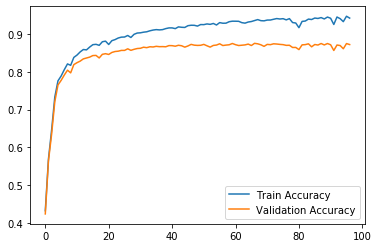

In [21]:
plt.plot(clf.history['train_balanced_accuracy'], label='Train Accuracy')
plt.plot(clf.history['valid_balanced_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

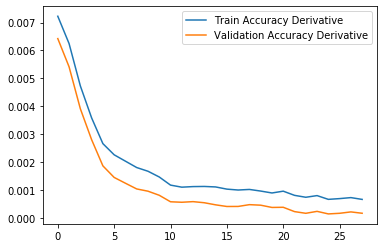

In [22]:
n_window = 70
plt.plot(np.gradient(pd.Series(clf.history['train_balanced_accuracy']).rolling(window=n_window).mean().iloc[n_window-1:].values), label='Train Accuracy Derivative')
plt.plot(np.gradient(pd.Series(clf.history['valid_balanced_accuracy']).rolling(window=n_window).mean().iloc[n_window-1:].values), label='Validation Accuracy Derivative')
plt.legend()
plt.show()

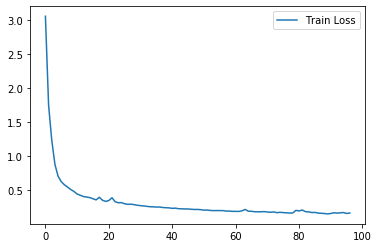

In [23]:
plt.plot(clf.history['loss'], label='Train Loss')
plt.legend()
plt.show()

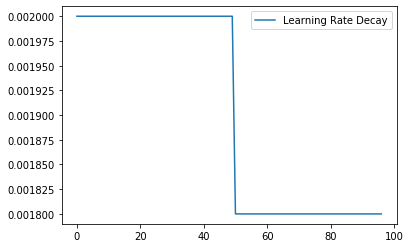

In [24]:
plt.plot(clf.history['lr'], label='Learning Rate Decay')
plt.legend()
plt.show()

* Prediction

In [25]:
start_time = time.time()

y_predict = clf.predict(std_scaler.fit_transform(x_test))

print(str(round((time.time() - start_time)/60,1)) + ' minutes taken') 

0.1 minutes taken


    * Metrics

In [26]:
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score

print('Accuracy: ', str(accuracy_score(y_test, y_predict)), '\n')
print('########################', '\n')
print('Balanced Accuracy: ', str(balanced_accuracy_score(y_test, y_predict)))
print('########################', '\n')
print('F1-Score Micro: ', str(f1_score(y_test, y_predict, average='weighted')))

Accuracy:  0.7717836518282298 

######################## 

Balanced Accuracy:  0.8725563059374138
######################## 

F1-Score Micro:  0.783634621399808


* Feature Importance

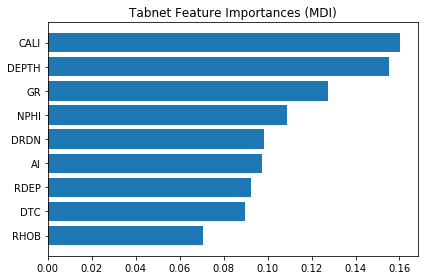

In [27]:
tab_feature_importances = (clf.feature_importances_)
sorted_idx = tab_feature_importances.argsort()
y_ticks = np.arange(0, len(X.columns))
fig, ax = plt.subplots()
ax.barh(y_ticks, tab_feature_importances[sorted_idx])
ax.set_yticklabels(X.columns[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Tabnet Feature Importances (MDI)")
fig.tight_layout()
plt.show()

* Confusion Matrix

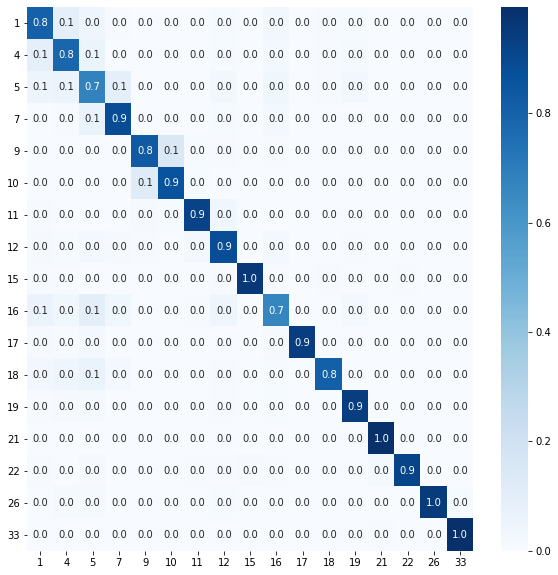

In [28]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_predict)

fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis], cmap=plt.cm.Blues, annot=True, fmt='.1f', xticklabels=np.sort(Y.unique())
, yticklabels=np.sort(Y.unique())
) # confusion matrix normalized as in Sklearn documentation

plt.yticks(rotation=0) 

plt.show()